In [422]:
import os
import sklearn

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import r2_score, explained_variance_score, max_error

In [451]:
import pickle

In [369]:
base_path = os.getcwd()
dat = pd.read_csv(f'{base_path}/env/data/train.csv')

In [370]:
dat = dat.drop('Id', axis=1)

In [371]:
dat.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


With the data set loaded we need to identify the categorical data from the numeric data, as the categorical data will need to be transformed in some manner before prediction (It's good practice to transform the numeric data too, either to standardize it or for identifying outliers).

# EDA

We need to dig into the data more deeply, starting with missing values we'll look at the best way to handle them.

In [372]:
# Quantify amount of missing data
null_values = (np.sum(dat.isna()))[np.sum(dat.isna()) > 0]
prop = (np.sum(dat.isna()) / dat.shape[0])[np.sum(dat.isna()) > 0] * 100
missing_data = pd.concat([null_values, prop], axis=1, keys=['Total', 'Percentage'])
missing_data.sort_values(by='Total', ascending=False)

,Total,Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945


The variables with the most missing data `PoolQC, MiscFeature, Alley, Fence, FireplaceQu`, are all categorical variables. We can create a one hot encoding column to denote if the values are missing or not.

In [373]:
dat[['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']].describe()

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu
count,7,54,91,281,770
unique,3,4,2,4,5
top,Gd,Shed,Grvl,MnPrv,Gd
freq,3,49,50,157,380


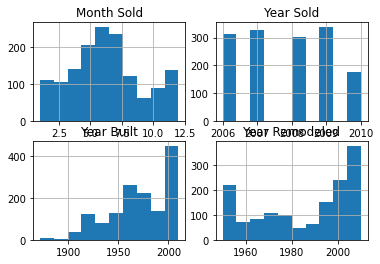

In [374]:
plt.subplot(221)
dat.MoSold.hist()
plt.title('Month Sold')
plt.subplot(222)
dat.YrSold.hist()
plt.title('Year Sold')
plt.subplot(223)
dat.YearBuilt.hist()
plt.title('Year Built')
plt.subplot(224)
dat.YearRemodAdd.hist()
plt.title('Year Remodeled')
plt.show()

# Feature Engineering

In [375]:
dat['Remodeled'] = (dat.YearRemodAdd != dat.YearBuilt) * 1

In [376]:
dat['Years_Since_Remodel'] = dat.YearRemodAdd - dat.YearBuilt
dat['Home_Age'] = dat.YrSold - dat.YearBuilt

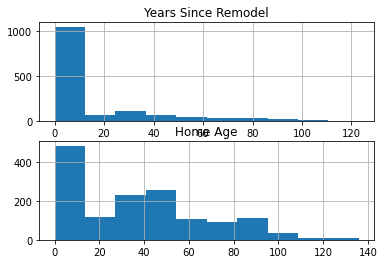

In [377]:
plt.subplot(211)
dat.Years_Since_Remodel.hist()
plt.title('Years Since Remodel')
plt.subplot(212)
dat.Home_Age.hist()
plt.title('Home Age')
plt.show()

In [378]:
dat.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Remodeled,Years_Since_Remodel,Home_Age
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,0,2,2008,WD,Normal,208500,0,0,5
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,0,5,2007,WD,Normal,181500,0,0,31
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,0,9,2008,WD,Normal,223500,1,1,7
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,0,2,2006,WD,Abnorml,140000,1,55,91
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,0,12,2008,WD,Normal,250000,0,0,8


In [380]:
# Identify numerical data type columns
num_cols = list(dat.columns[dat.dtypes == np.int64])
num_cols += list(dat.columns[dat.dtypes == np.float64])

# Identify categorical data type columns
cat_cols = list(set(dat.columns) - set(num_cols))

In [381]:
drops = ['Alley', 'PoolQC', 'Fence', 'FireplaceQu', 'MiscFeature', 'SalePrice']
na_cols = ['Alley', 'PoolQC', 'Fence', 'FireplaceQu', 'MiscFeature']

In [382]:
cat_cols = list(set(cat_cols) - set(drops))
num_cols = list(set(num_cols) - set(drops))

In [383]:
dat['cat_YrSold'] = dat.YrSold.astype(str)
dat['cat_MoSold'] = dat.MoSold.astype(str)
cat_cols += ['cat_YrSold', 'cat_MoSold']

In [384]:
cat_lens = {}
for c in cat_cols:
    cat_lens[c] = dat[c].nunique()

pd.DataFrame({'Variable': cat_lens.keys(), 'Unique Count': cat_lens.values()}).sort_values(by = 'Unique Count', ascending=False).head(10)

,Variable,Unique Count
0,Neighborhood,25
8,Exterior2nd,16
9,Exterior1st,15
39,cat_MoSold,12
7,SaleType,9
24,Condition1,9
5,Condition2,8
35,RoofMatl,8
31,HouseStyle,8
16,Functional,7


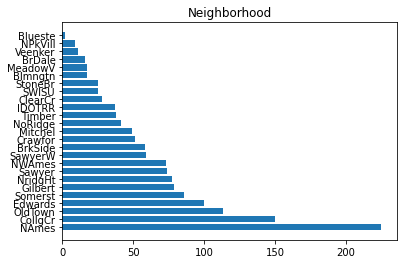

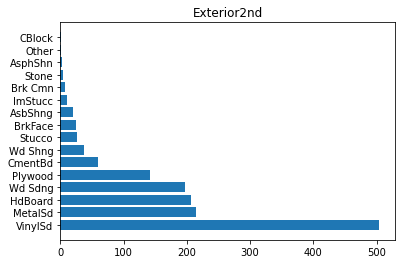

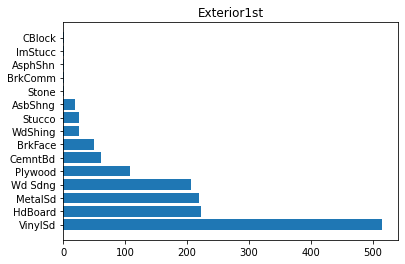

In [385]:
for c in ['Neighborhood', 'Exterior2nd', 'Exterior1st']:
    vals = dat[c].value_counts()
    labs = dat[c].value_counts().keys()
    plt.barh(labs, vals)
    plt.title(c)
    plt.show()

In [386]:
cat_categories = []
for c in cat_cols:
    cat_categories.append(list(set(dat[c])))

After dropping variables that were missing a substantial amount of data we can go on to encode the categorical variables via one hot encoding.

In [387]:
enc = OneHotEncoder(categories=cat_categories, handle_unknown='ignore')
enc.fit(dat[cat_cols])
enc.transform(dat[cat_cols]).toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [452]:
# Save encoder
filename = 'encoder.pkl'
with open(filename, 'wb') as file:
    pickle.dump(enc, file)

In [453]:
# Load encoder
filename = 'encoder.pkl'
with open(filename, 'rb') as file:
    pkl_enc = pickle.load(file)

With the data encoded and the encoder fit to the training data it's time to impute the missing values of the data set. We'll use KNN imputation to fill in any missing values in the data set.

In [454]:
dat_imp = pd.concat([pd.DataFrame(enc.transform(dat[cat_cols]).toarray()), dat[num_cols], dat[na_cols].isna() * 1], axis=1)

In [455]:
imputer = KNNImputer(n_neighbors=5)
x_train = imputer.fit_transform(dat_imp)
y_train = dat.SalePrice

In [456]:
x_train.shape

(1460, 306)

# Train the Model

There is usually a bit more to training the model than just passing a training data set and letting it build, however the default model works alright in this case so we'll train a gradient boosted regressor model on our newly transformed and imputed data set.

In [438]:
param_grid = {
    'loss': ('ls', 'huber', 'quantile'),
    'learning_rate': list(np.linspace(0.01, 0.3, 20)),
    'n_estimators': list(np.linspace(100, 300, 20, dtype=int)),
    'criterion': ('friedman_mse', 'mse'),
    'subsample': list(np.linspace(0.4, 1, 20)),
    'max_depth': list(np.linspace(1, 12, 12, dtype=int))
    }

base_estimator = GradientBoostingRegressor()
sh = HalvingRandomSearchCV(estimator=base_estimator, param_distributions=param_grid, scoring='explained_variance', cv=4, factor=3, max_resources='auto', aggressive_elimination=False).fit(x_train, y_train)

In [439]:
hp_df = pd.DataFrame(sh.cv_results_)
drops = ['iter', 'n_resources', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score']
hp_df = hp_df.drop(drops, axis=1)

In [440]:
hp_df.head(5)

,param_subsample,param_n_estimators,param_max_depth,param_loss,param_learning_rate,param_criterion,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.463158,163,2,quantile,0.208421,mse,"{'subsample': 0.4631578947368421, 'n_estimator...",-9.594164,17.844119,159,0.999391,8.365752e-04
1,0.494737,215,11,quantile,0.284737,friedman_mse,"{'subsample': 0.4947368421052632, 'n_estimator...",-0.251029,1.649513,107,1.000000,1.074547e-07
2,0.747368,236,1,huber,0.040526,friedman_mse,"{'subsample': 0.7473684210526317, 'n_estimator...",-28.477259,50.948878,201,0.999927,3.142926e-05
3,0.526316,194,9,quantile,0.223684,friedman_mse,"{'subsample': 0.5263157894736843, 'n_estimator...",-7.556452,14.734837,146,0.999999,8.409399e-07
4,0.810526,173,12,ls,0.040526,friedman_mse,"{'subsample': 0.8105263157894738, 'n_estimator...",-3.716022,7.953803,130,0.999855,1.690683e-05


In [441]:
# "Best" model hyperparameters
hp_df.loc[hp_df.rank_test_score == 1].params.values[0]

{'subsample': 0.5263157894736843,
 'n_estimators': 257,
 'max_depth': 8,
 'loss': 'ls',
 'learning_rate': 0.20842105263157895,
 'criterion': 'mse'}

In [442]:
# Default model parameters
params = {
    'loss': 'ls',
    'learning_rate': 0.05,
    'n_estimators': 200,
    'criterion': 'mse',
    'subsample': 0.8,
    'max_depth': 5
}

# Default model
model = GradientBoostingRegressor(**params)

In [443]:
# HP job parameters
params = hp_df.loc[hp_df.rank_test_score == 1].params.values[0]

# HP job model
model = sh.best_estimator_

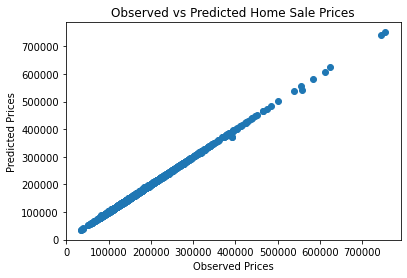

In [444]:
plt.scatter(y_train, model.predict(x_train))
plt.xlabel('Observed Prices')
plt.ylabel('Predicted Prices')
plt.title('Observed vs Predicted Home Sale Prices')
plt.show()

In [445]:
print(f'Training Data Correlation: {r2_score(y_train, model.predict(x_train))}')
print(f'Training Data Explained Variance: {explained_variance_score(y_train, model.predict(x_train))}')
print(f'Training Data Max Error: {max_error(y_train, model.predict(x_train))}')

Training Data Correlation: 0.9997763498568182
Training Data Explained Variance: 0.9997765130195538
Training Data Max Error: 21022.36969174567


In [446]:
test_dat = pd.read_csv(f'{base_path}/env/data/test.csv')

In [447]:
test_dat['Remodeled'] = (test_dat.YearRemodAdd != test_dat.YearBuilt) * 1
test_dat['Years_Since_Remodel'] = test_dat.YearRemodAdd - test_dat.YearBuilt
test_dat['Home_Age'] = test_dat.YrSold - test_dat.YearBuilt
test_dat['cat_YrSold'] = test_dat.YrSold.astype(str)
test_dat['cat_MoSold'] = test_dat.MoSold.astype(str)

In [448]:
enc.transform(test_dat[cat_cols]).toarray()
test_imp = pd.concat([pd.DataFrame(enc.transform(test_dat[cat_cols]).toarray()), test_dat[num_cols], test_dat[na_cols].isna() * 1], axis=1)
x_test = imputer.transform(test_imp)

With the test data formatted we can now generate the output for Kaggle submissions, to do this we'll use pandas to write out a dataframe with the `Id` and corresponding `SalePrice` predictions.

In [449]:
output = pd.DataFrame({'Id': test_dat.Id, 'SalePrice': model.predict(x_test)})

In [450]:
output.to_csv(f'{base_path}/env/data/jdym_submission.csv', index=False)